In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import sys
sys.path.append("..")
sys.path.append("../Examples")


from toy_mdp_helper import generate_dataset, evaluate_diffusionQ, extract_deterministic_policy, visualize_policy_heatmap
from toy_mdp_helper import  visualize_policy_heatmap_continuous

In [4]:
hyperparams = {
    'N_diffusion_steps':30,
    'schedule_type': "vp",
    'abs_action_max': 1.0,
    'gamma': 0.99,
    'lr': 5e-3,
    'decay_lr': False,
    'weight_decay': 0.001,
    'num_critics': 2,
    'lcb_coef': 0.0,
    'q_sample_eta': 1.0,
    'weight_entropy_loss': 0.0,
    'weight_q_loss': 1.0,
    'approximate_action': True,
    'ema_tau': 0.005,
    'ema_period': 20,
    'ema_begin_update': 1000,
    'layer_norm': False,
    'device': 'cuda',
}

N_s = 10
N_a = 10
LEN_dataset = 5000

rb_capacity = LEN_dataset
dataset, policy_mdp, P, R = generate_dataset(LEN_dataset, N_s, N_a, seed=995)

from DiffusionQL.DQL_Q_esmb import DQL_Q_esmb as Agent
print(f"Expert's Reward:{np.mean(dataset['rewards'])}")


sample_method = "EAS" 
agent = Agent(state_dim=1, action_dim=1, **hyperparams)
agent.load_model("../Examples/Results/mdp", "best")
  
eta = 5.0
_, frequency_DQ_eta_large = extract_deterministic_policy(
    agent, N_s, N_a, sample_method=sample_method, N_sample=50, N_sampling=1000, eta=eta)
eta = 0.01
_, frequency_DQ_eta_small = extract_deterministic_policy(
    agent, N_s, N_a, sample_method=sample_method, N_sample=50, N_sampling=1000, eta=eta)


Value Iteration: 100%|██████████| 1000/1000 [00:00<00:00, 1434.38it/s, V=-87.638921]


Expert's Reward:0.874268878606705


c:\Users\Ye\Documents\YuYeh_Documents\L2S\Projects\diffusion_resource_schduling_intra_slice\Figures\..\DiffusionQL\DQL_Q_esmb.py:208: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

In [5]:
import sys
sys.path.append("../../Benchmarks/Diffusion-Policies-for-Offline-RL")

from toy_experiments.toy_helpers import Data_Sampler_full
from agents.ql_diffusion import Diffusion_QL
from toy_mdp_helper_ext import generate_dataset
from toy_mdp_helper_ext import extract_deterministic_policy as extract_deterministic_policy_benchmark
from toy_mdp_helper_ext import evaluate_diffusionQ as evaluate_diffusionQ_ext 

def prepare_data(N_s = 10, N_a = 10, LEN_dataset = 5000, device = 'cuda:0'):
    dataset, policy_mdp, P, R = generate_dataset(LEN_dataset, N_s, N_a, seed=995)

    data_sampler = Data_Sampler_full(
        np.array(dataset['observations']),
        np.array(dataset['actions']),
        np.array(dataset['rewards']),
        np.array(dataset['next_observations']),
        np.zeros_like(np.array(dataset['observations'])),
        device=device)
    return data_sampler, dataset, policy_mdp, P, R

agent_kwargs = {
    "max_action": 1.0,
    "device": "cuda:0",
    "discount": 0.99,
    "tau": 0.005,
    "max_q_backup": True,
    "eta": 1.0,
    "beta_schedule": 'vp',
    "n_timesteps": 10,
    "ema_decay": 0.995,
    "step_start_ema": 100,
    "update_ema_every": 5,
    "lr": 5e-3,
    "lr_decay": True,
    "lr_maxt": 1000,
    "grad_norm": 1.0
}

state_dim = 1
action_dim = 1
N_s = 10
N_a = 10
LEN_dataset = 5000
data_sampler, dataset, policy_mdp, P, R = prepare_data(N_s, N_a, LEN_dataset)

iterations = 1000
num_epochs = 10
batch_size = 100

agent_ext = Diffusion_QL(
    state_dim,
    action_dim,
    **agent_kwargs)

agent_ext.load_model("../../Benchmarks/Diffusion-Policies-for-Offline-RL/Models", 'best')
_, frequency_ext = extract_deterministic_policy_benchmark(agent_ext, N_s, N_a, N_sampling=200)

Value Iteration: 100%|██████████| 1000/1000 [00:00<00:00, 1521.77it/s, V=-87.638921]
c:\Users\Ye\Documents\YuYeh_Documents\L2S\Projects\diffusion_resource_schduling_intra_slice\Figures\../../Benchmarks/Diffusion-Policies-for-Offline-RL\agents\ql_diffusion.py:208: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case whe

Plot saved to: C:/Users/Ye/Documents/YuYeh_Documents/L2S/Conference_Writing/Globecom25_workshop/Diffusion policy for intra-slice resource scheduling/Figures\continuous_policy.png


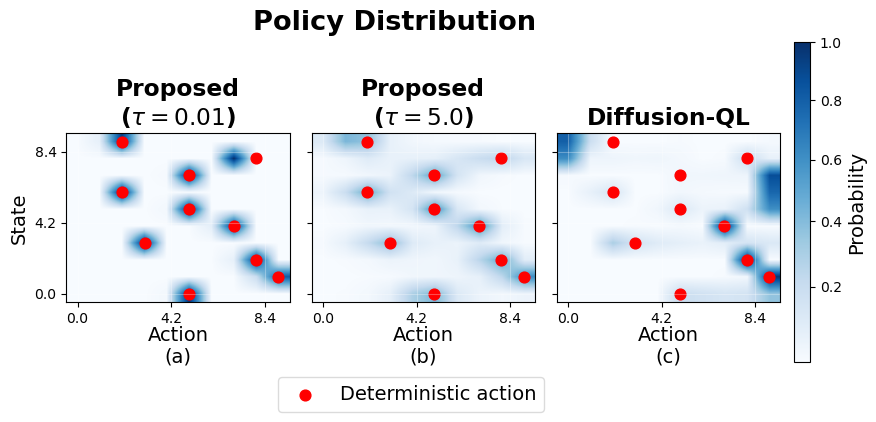

In [8]:
parentFolder = "C:/Users/Ye/Documents/YuYeh_Documents/L2S/Conference_Writing/Globecom25_workshop/Diffusion policy for intra-slice resource scheduling/Figures"
visualize_policy_heatmap_continuous(
    frequency_heatmaps=[frequency_DQ_eta_small, frequency_DQ_eta_large, frequency_ext],
    policy_deterministic_list=[policy_mdp, policy_mdp, policy_mdp],
    main_title="Policy Distribution",
    titles = ["Proposed\n($\\tau=0.01$)", "Proposed\n($\\tau=5.0$)", "Diffusion-QL"],
    save_path=os.path.join(parentFolder, "continuous_policy.png"),
    figsize=(8, 4),
    font_scale=1.4,
    interpolation="bilinear",
    xtick_step=3,
    ytick_step=3,
    gamma=0.9,
    bbox_to_anchor=(0.52, -0.05),
    cbar_pos=(0.999, 0.1, 0.02, 0.8)
)


In [7]:
records = {'large_eta': [], 'small_eta': [], 'ext': []}

for i in range(10):
    eta = 5.0
    reward_large_eta, _ = evaluate_diffusionQ(agent, R, P, N_s, N_a, N_iter=50, sample_method=sample_method, N_sample=50, eta=eta)
    eta = 0.01
    reward_small_eta, _ = evaluate_diffusionQ(agent, R, P, N_s, N_a, N_iter=50, sample_method=sample_method, N_sample=50, eta=eta)
    reward_ext, _ = evaluate_diffusionQ_ext(agent_ext, R, P, N_s, N_a, N_iter=50)
    records['large_eta'].append(reward_large_eta)
    records['small_eta'].append(reward_small_eta)
    records['ext'].append(reward_ext)

import scipy.stats as stats

def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    se = stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

mean_large, ci_large = mean_confidence_interval(records['large_eta'])
mean_small, ci_small = mean_confidence_interval(records['small_eta'])
mean_ext, ci_ext = mean_confidence_interval(records['ext'])

print(f"reward_large_eta: {mean_large:.3f} ± {ci_large:.3f}")
print(f"reward_small_eta: {mean_small:.3f} ± {ci_small:.3f}")
print(f"reward_ext: {mean_ext:.3f} ± {ci_ext:.3f}")

reward_large_eta: 0.633 ± 0.031
reward_small_eta: 0.819 ± 0.012
reward_ext: 0.623 ± 0.034
